# On-The-Fly (OTF) Data Reduction

This notebook shows how to use `dysh` to calibrate and grid an *On-The-Fly* (OTF) observation. See [Mangum et al. (2007)](https://ui.adsabs.harvard.edu/abs/2007A%26A...474..679M) for the background on this method.

OTF observations can be calibrated in `dysh`, however, generating FITS cubes requires the use of additional applications.

The workflow to go from raw data to a FITS cube would then require the following steps:

1. Calibrate the data using `dysh`. This can include baseline subtraction, altough in some cases baseline removal is more effective in a FITS cube.

2. Write the calibrated spectra to a format compatible with the gridding tool being used. For GBT observations the recommended format is SDFITS and the tool to grid the data is the [gbtgridder](https://github.com/GreenBankObservatory/gbtgridder/tree/release_3.0).

3. Baseline subtraction in the FITS cube. This is optional, depending on the data quality, and `dysh` does not provide convenience functions for this.

## Dysh commands

The following dysh commands are introduced (leaving out all the function arguments):

      filename = dysh_data()
      sdf = GBTFITSLoad()
      sb = sdf.getsigref()
      ta = sb.timeaverage()
      ta.baseline()
      ta.plot()

## Loading Modules
We start by loading the modules we will use for the data reduction. 

For display purposes, we use the static (non-interactive) `matplotlib` backend in this tutorial. However, you can tell `matplotlib` to use the `ipympl` backend to enable interactive plots. This is only needed if working on `jupyter` lab or notebook.

In [1]:
# We use dysh_data to retrieve the example data set.
from dysh.util.files import dysh_data

# This is required to load and calibrate the example data set.
from dysh.fits.gbtfitsload import GBTFITSLoad
from dysh.log import init_logging

## Setup
We start the dysh logging, so we get more information about what is happening.
This is only needed if working on a notebook.
If using the CLI through the ``dysh`` command, then logging is setup for you.

In [2]:
init_logging(2)

## Data Retrieval

Download the example SDFITS data, if necessary.

In [3]:
# filename = dysh_data(example='mapping-L/data/TGBT17A_506_11.raw.vegas/TGBT17A_506_11.raw.vegas.A.fits')
filename = dysh_data(example='otf1')

10:44:20.176 I Resolving example=otf1 -> mapping-L/data/TGBT17A_506_11.raw.vegas/


In [4]:
sdfits = GBTFITSLoad(filename)

In [5]:
sdfits.summary()

SCAN,OBJECT,VELOCITY,PROC,PROCSEQN,RESTFREQ,DOPFREQ,# IF,# POL,# INT,# FEED,AZIMUTH,ELEVATION
6,3C286,0.0,OnOff,1,1.6168,1.420406,5,2,13,1,248.3657,72.5531
7,3C286,0.0,OnOff,2,1.6168,1.420406,5,2,13,1,250.0385,73.6777
8,SgrB2M,57.0,Track,1,1.6168,1.420406,5,2,61,1,142.3845,12.2545
9,W33B,64.0,Track,1,1.6168,1.420406,5,2,61,1,132.2057,17.9786
10,G30.589-0.044,38.0,Track,1,1.6168,1.420406,5,2,61,1,115.4811,25.5523
11,G31.412+0.307,97.0,Track,1,1.6168,1.420406,5,2,61,1,115.8034,27.0986
12,G35.577-0.029,49.0,Track,1,1.6168,1.420406,5,2,61,1,112.3139,29.0337
13,G40.622-0.137,32.0,Track,1,1.6168,1.420406,5,2,61,1,107.7736,31.3159
14,NGC6946,45.0,DecLatMap,1,1.6168,1.420406,5,2,61,1,38.9626,41.3644
15,NGC6946,45.0,DecLatMap,2,1.6168,1.420406,5,2,61,1,38.9910,41.4488


In this particular observation the OTF slew over the galaxy NGC6946 in scans 14-26, followed by an Off position scan 27. Each **SCAN**, in this case, corresponds to a row, with 61 integrations as the telescope slews slowly over the sky.

## Data Reduction

We use `getsigref` to calibrate the OTF scans using scan 27 as the reference position.
`getsigref` takes as input a list of scan numbers, or a single one, and a number, or `Spectrum`, for the reference position.
It calibrates all the input scans using
$$
T_{\mathrm{A}}=T_{\mathrm{sys}}\frac{P_{\mathrm{sig}}-P_{\mathrm{ref}}}{P_{\mathrm{ref}}},
$$
where $T_{\mathrm{sys}}$ is the system temperature derived from the reference scan, $P_{\mathrm{sig}}$ is the raw power in the input scans (the signal), and $P_{\mathrm{ref}}$ is the raw power in the reference scan.

We start by defining the variables we will use to calibrate the 21 cm-HI line observations present in this data set.

In [6]:
ifnum = 0                     # The 21 cm line is in the spectral window labeled 0.
fdnum = 0                     # Only one feed in this data set
ref   = 27                    # The reference ("OFF") scan
scans = list(range(14,27))    # The signal ("ON") scans 14..26

Now, we calibrate a single polarization.
The processing for the second polarization should be almost identical.

In [7]:
sb0 = sdfits.getsigref(scan=scans, ref=ref, fdnum=fdnum, ifnum=ifnum, plnum=0)

10:44:44.815 I Ignoring 1 blanked integration(s).
10:44:50.963 I Ignoring 1 blanked integration(s).
10:44:51.216 I Ignoring 1 blanked integration(s).
10:44:51.474 I Ignoring 1 blanked integration(s).
10:44:51.739 I Ignoring 1 blanked integration(s).
10:44:51.994 I Ignoring 1 blanked integration(s).
10:44:52.267 I Ignoring 1 blanked integration(s).
10:44:52.559 I Ignoring 1 blanked integration(s).
10:44:52.836 I Ignoring 1 blanked integration(s).
10:44:53.105 I Ignoring 1 blanked integration(s).
10:44:53.364 I Ignoring 1 blanked integration(s).
10:44:53.640 I Ignoring 1 blanked integration(s).
10:44:53.936 I Ignoring 1 blanked integration(s).
10:44:54.232 I Ignoring 1 blanked integration(s).


The return from `getsigref` is a `ScanBlock` with `PSScan`s in it.

In [8]:
sb0

ScanBlock([<dysh.spectra.scan.PSScan at 0x7f634727af10>,
           <dysh.spectra.scan.PSScan at 0x7f6384d52890>])

### Data Inspection

After calibrating the data, we can inspect the calibrated data using the plotting methods available in `dysh`.
First, we will extract a single spectrum from the middle of the observations and plot it. 
To get the spectrum from the middle of the OTF map, we use `len(sb0)//2` to specify the middle scan and `sb0[len(sb0)//2].nint//2` to specify the middle integration (in this case there are 61 integrations).
We store the number of integrations in the `nint` variable to reuse it later.

In [9]:
nint = sb0[len(sb0)//2].nint
spec = sb0[len(sb0)//2].getspec(nint//2)

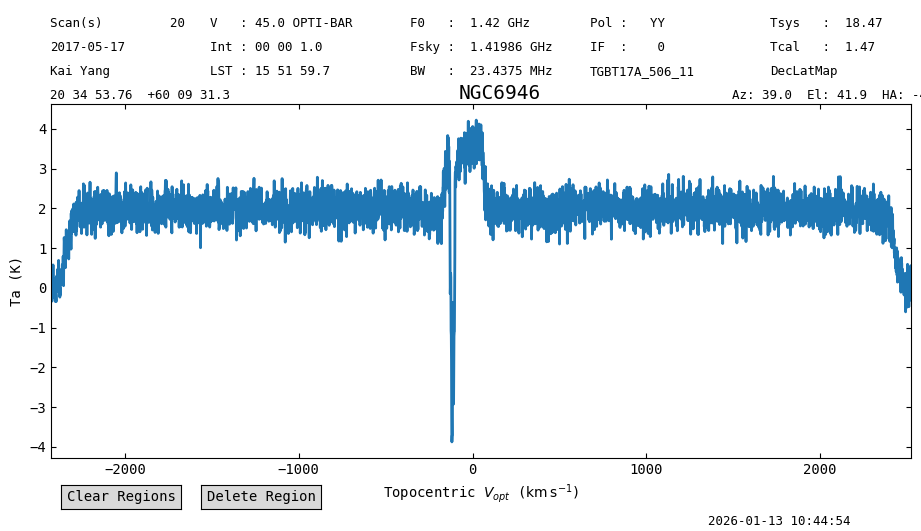

In [10]:
sp = spec.plot(xaxis_unit="km/s")

A clear and strong signal is present, as well as a ~2 K continuum. There is also an obvious negative signal, most likely local HI since the Off position will never be line free near vlsr ~ 0

Now we will plot the time average for the middle scan.

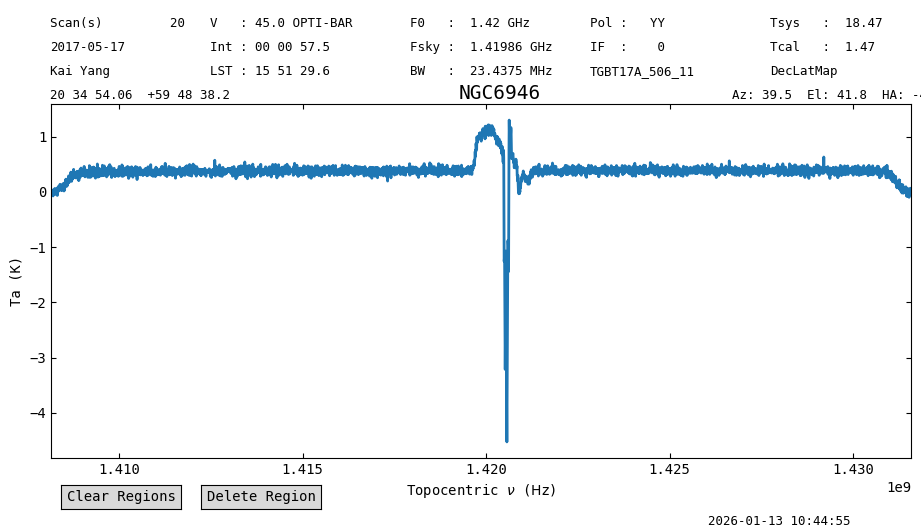

In [11]:
spec_avg = sb0[len(sb0)//2].timeaverage()
sp_avg = spec_avg.plot()

Again, a clear signal, but the line brightness and continuum are lower due to the dilution from the time averaging. This is because the source is smaller than the area mapped, so the signal gets averaged with empty sky.

### Baseline Subtraction

If we are only interested in the spectral line, then we use baseline subtraction to remove the continuum.
We will use an order 1 polynomial to remove the continuum, and make sure to exclude the edge channels as well as the channels with 21 cm signal during the baseline fit.

We explore two approaches to continuum subtraction (baseline removal), using a model derived from a time average and deriving a baseline for each integration.

#### Using a Time Average

We start by using the time average of the spectra in one scan to derive a baseline model, and then we will use this baseline model to subtract the continuum from all of the integrations in the scan.
This approach has the benefit of being faster than deriving a baseline from each integration, and the spectrum used to derive the baseline model has a higher signal-to-noise.
However, this approach requires that the baseline be stable in time/sky position.
If that is not the case, then there will be left over baseline/continuum in the baseline subtracted data.

We start by plotting the time average as a function of channel number to determine where the 21 cm signal is.

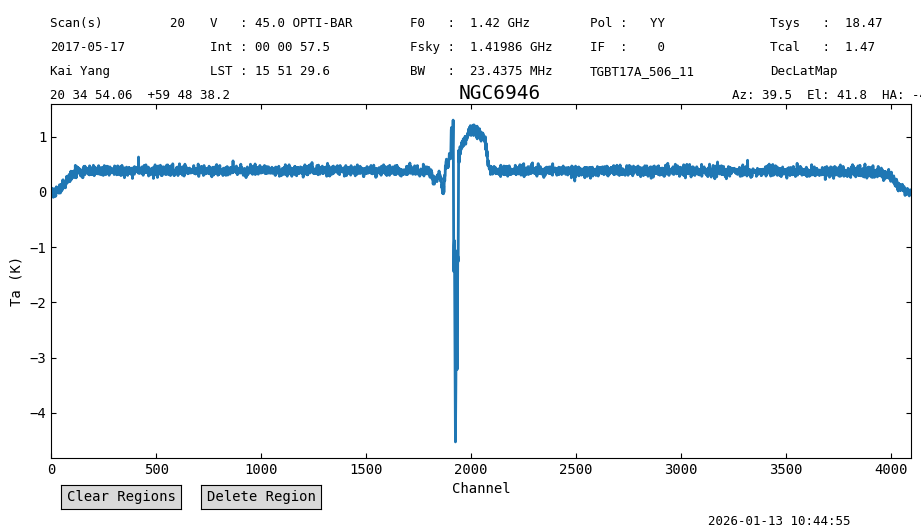

In [12]:
sp_avg.plot(xaxis_unit="channel")

From the plot we see that channels ~1600 to 2250 have 21 cm signal, and the edges are between 0 and 250, and 4095-250 and 4095.
We define an exclude region with these.

In [13]:
exclude = [(0,250),
           (1600,2250),
           (4095-250,4095)]

Now do the baseline fitting, using an order 1 polynomial and removing the best fit model from the data.

In [14]:
spec_avg.baseline(1, model="poly", exclude=exclude, remove=True)

10:44:55.631 I EXCLUDING [Spectral Region, 1 sub-regions:
  (1408148687.1396484 Hz, 1409579198.6142578 Hz) 
, Spectral Region, 1 sub-regions:
  (1418705861.8222656 Hz, 1422425191.65625 Hz) 
, Spectral Region, 1 sub-regions:
  (1430149953.6191406 Hz, 1431580465.09375 Hz) 
]


Plot the baseline subtracted data.
(Alternatively, one could use `spec_avg.plot()`.)

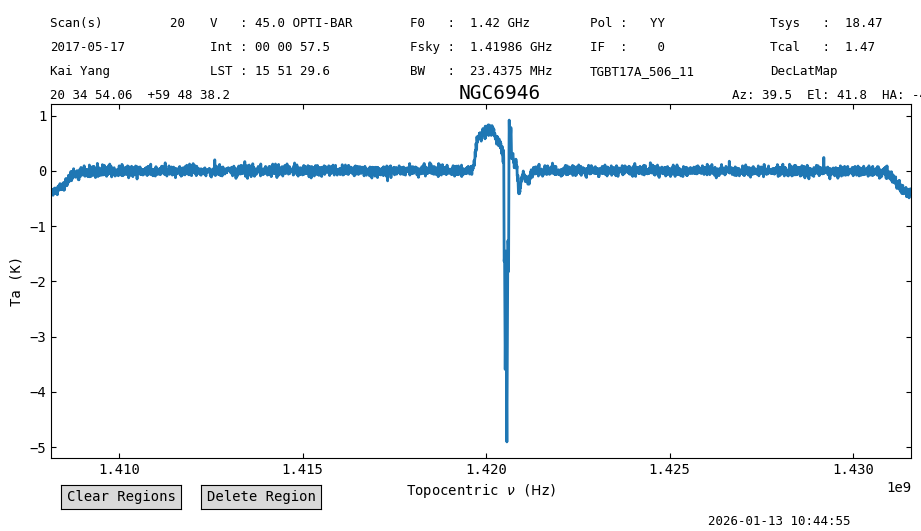

In [15]:
sp_avg.plot()

The continuum has been removed (the spectrum is centered around 0 K). 
We can look at the statistics to verify this.

In [16]:
spec_avg.stats()    # rms 0.25388794 K  

10:44:55.956 W Warning: 0 != 2: inconsistency counters in mask usage


{'mean': <Quantity -0.00863779 K>,
 'median': <Quantity -0.00468249 K>,
 'rms': <Quantity 0.25388794 K>,
 'min': <Quantity -4.90320558 K>,
 'max': <Quantity 0.91798011 K>,
 'npt': 4096,
 'nan': 2}

The mean is around -8.6 mK, the median -4.5 mK and the rms 0.25 K.

We can subtract this baseline model from all of the integrations using the `subtract_baseline` method of a `ScanBlock` or `Scan`.
The input to `subtract_baseline` should be a baseline model, which can be accessed through the `baseline_model` attribute of a `Spectrum` object.

In [17]:
sb0[len(sb0)//2].subtract_baseline(spec_avg.baseline_model)

Generate a time average again to see how the data changed after the baseline subtraction.

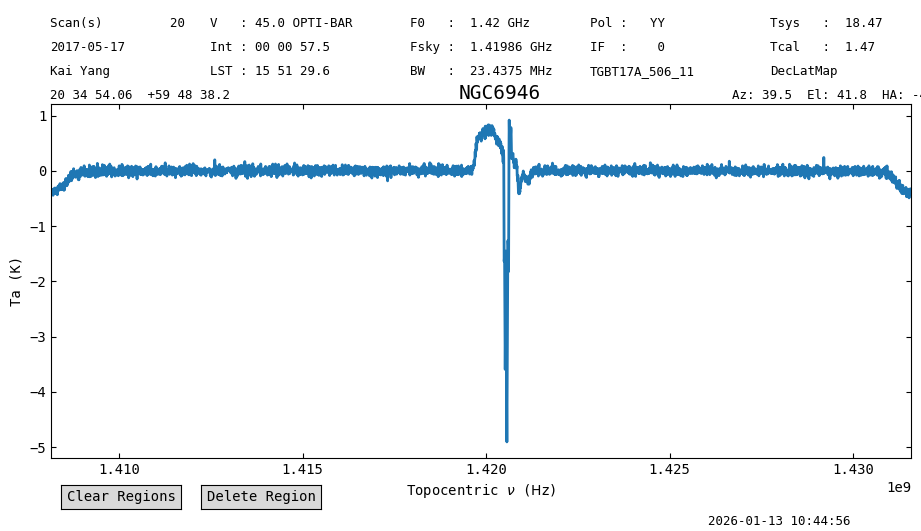

In [18]:
spec_avg_bsub = sb0[len(sb0)//2].timeaverage()
sp_avg_bsub = spec_avg_bsub.plot()

The time average for the middle scan of the OTF map is now centered around zero as expected.
However, since we used the diluted time average for the middle scan as our baseline model, the spectra that cover the source still have continuum left.

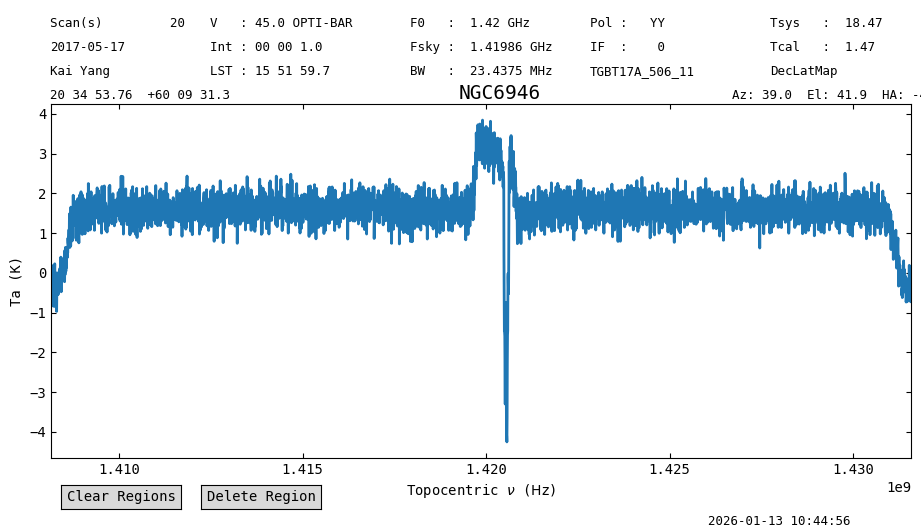

In [19]:
spec_bsub = sb0[len(sb0)//2].getspec(nint//2)
sp_spec_bsub = spec_bsub.plot()

#### Using the Integrations

Now we will repeat the calibration, but deriving a baseline model from each integration.
This is slower, so we only do this for the middle scan of the OTF map.
This approach has the benefit of being more flexible than the previous one, however the signal-to-noise is worse.

To access the data for the integrations we will use the `calibrated` method and the `_calibrated` property of a `Scan`.
`calibrated` returns the data for a specific integration (starting at 0) as a `Spectrum` object, while `_calibrated` is the array that contains the calibrated data for the `Scan`. 
We will use the `Spectrum` to derive the baseline, and then update the data by updating the `_calibrated` property of the `Scan`.

We put the middle scan of the OTF map in a new variable `scan`, then loop over its integrations fitting a baseline model and subtracting it from the calibrated data. 
We ignore integrations that were blanked (all values would be NaN).
We use the `math` library to check for NaNs.

In [20]:
import math # Load the `math` library. Use this instead of `numpy` to save memory.

In [21]:
scan = sb0[len(sb0)//2]

for i,_c in enumerate(scan.calibrated):
    if math.isnan(_c.data.sum()):
        # If the sum is NaN, then skip (continue) this item.
        # This is not a great solution, as even a single NaN value
        # in the spectrum would cause the sum to be NaN,
        # but there should be no NaN values for single channels
        # in this data set.
        continue
    s_i = scan.getspec(i) # Fetch the `Spectrum` for integration `i`.
    s_i.baseline(1, model="poly", exclude=exclude, remove=True) # Fit a baseline model.
    scan.calibrated[i] -= s_i.baseline_model(s_i.spectral_axis).value # Subtract the baseline model from the data.

Plot the middle integration of the middle scan.

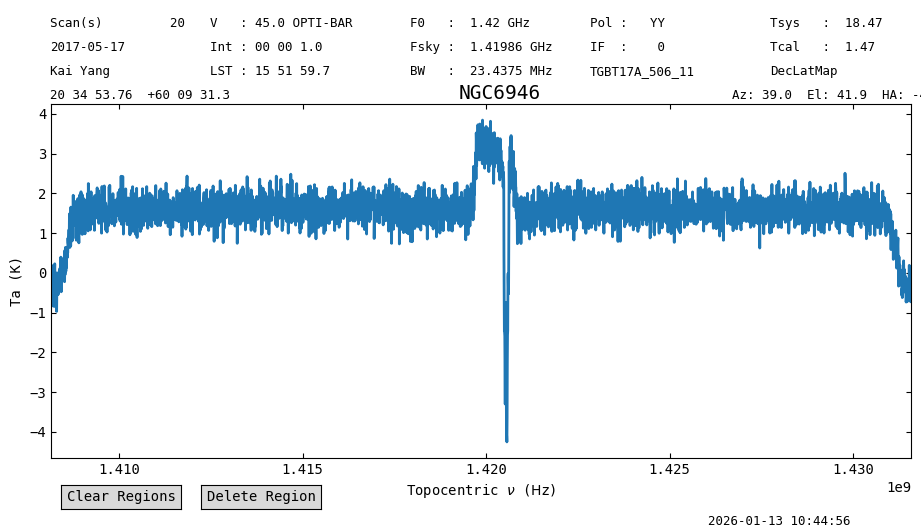

In [22]:
spec_bsub_int = sb0[len(sb0)//2].getspec(nint//2)
sp_spec_bsub_int = spec_bsub_int.plot()

Now the continuum has been removed.

We leave it as an exercise to repeat the above for every scan in the OTF map.
The answer is hidden below.

<details>
    <summary>Answer</summary>
    <pre>
        <code class="Python">
            for i,_s in enumerate(sb0):
                for j,_c in enumerate(_s._calibrated):
                    if math.isnan(_c.data.sum()):
                        # If the sum is NaN, then skip (continue) this item.
                        continue
                    s_i = getspec(j)
                    s_i.baseline(1, model="poly", exclude=exclude, remove=True)
                    _s._calibrated[j] -= s_i.baseline_model(s_i.spectral_axis).value
        </code>
    </pre>
    This can be speed up if we only create a <code>Spectrum</code> once, and then update its data attribute with the data for each integration before computing the baseline. That would be:
    <pre>
        <code class="Python">
            sp0 = sb0.timeaverage() 
            for i,_s in enumerate(sb0):
                for j,_c in enumerate(_s._calibrated):
                    if math.isnan(_c.data.sum()):
                        # If the sum is NaN, then skip (continue) this item.
                        continue
                    sp0._data = _s._calibrated[j] # Update the data of the `Spectrum`.
                    sp0.baseline(1, model="poly", exclude=exclude, remove=True)
                    _s._calibrated[j] -= sp0.baseline_model(sp0.spectral_axis).value
        </code>
    </pre>
</details>



## Writing the Data

After calibration, we write the data to disk in SDFITS format so it can be gridded by the [`gbtgridder`](https://github.com/GreenBankObservatory/gbtgridder) (GBO's supported data gridding tool).

In [23]:
sb0.write("otf_calibrated.fits", overwrite=True)

## Gridding

To grid GBT data GBO supports the use of the [`gbtgridder`](https://github.com/GreenBankObservatory/gbtgridder).
This is not included as part of `dysh`.

If you don't have it installed, here's a super short blurb how to get it, with the note that it is important to get the correct release branch at the time of this writing.

```bash
git clone -b release_3.0  https://github.com/GreenBankObservatory/gbtgridder
cd gbtgridder
pip install .
```

This was the situation in the summer of 2025, and it may change, be sure to be in touch with the `gbtgridder` developers.

After installation, either from the shell, or from the notebook, one can grid as follows:

```bash
gbtgridder --size 32 32  --channels 500:3500 -o otf --auto otf_calibrated.fits
```
This is telling the gridder to produce an output cube with 32 by 32 pixels using only channels between 500 and 3500, and to use "otf" as the name of the output files. The `--auto` part is to skip a confirmation prompt. The last argument, `otf_calibrated.fits`, is the input SDFITS (which was created in the previous cell).
This call to the `gbtgridder` will create two files: `otf_cube.fits` and `otf_weight.fits`.
The first file contains the gridded data, and the second the weights used during the gridding process.

### Working with Cubes

`dysh` is not meant to work with image cubes, there are plenty of great tools for this.
Here we show how to use `astropy` to load the FITS cube and visualize its contents.
We use `astropy.io.fits` to load the data, `astropy.wcs.WCS` to generate a World Coordinate System (WCS) representation out of the FITS header, this is handy for plotting.
And, `matplotlib.pyplot` to plot.

In [24]:
from astropy.io import fits
from astropy.wcs import WCS
import matplotlib.pyplot as plt

Before proceeding we download the cube, in case you did not make your own.

Note that this cube was made using data which had the baseline subtracted using a per integration model. 
If you generate your own cubes, there might be differences with respect to the cube used here.

In [25]:
cube_filename = dysh_data(example='mapping-L/outputs/otf_cube.fits')

Open the FITS cube, extract the data and header and then create a WCS object.

In [26]:
with fits.open(cube_filename) as hdu:
    data = hdu[0].data
    head = hdu[0].header
wcs = WCS(head)

The data object is an array with 4 dimensions, the first being the Stokes axis, the second the spectral axis, the third the latitude (e.g., Dec), and the fourth the longitude (e.g., RA). Altough the FITS cube has a Stokes axis, the `gbtgridder` does not handle polarizations properly, so if you have multiple polarizations in the input SDFITS file(s), the `gbtgridder` will average them.

To plot the spectrum from the center pixel we use.

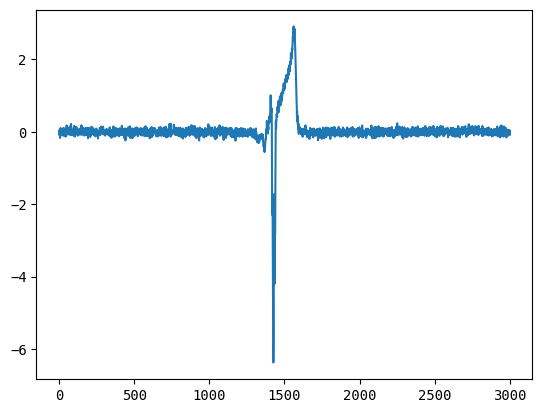

In [27]:
plt.figure()
plt.plot(data[0,:,16,16])

Now plot an image with the mean of the spectral axis.
We use the projection argument of `fig.add_subplot` to tell `matplotlib` to use the projection defined by the WCS object.
This takes care of using sky coordinates in the figure.
While plotting, `imshow`, we tell `matplotlib` to put the origin of the data, pixel (0,0), in the lower left corner (`origin="lower"`), and to automatically adjust the aspect ratio (`aspect="auto"`) for the axes (not really needed since the data is already a square).

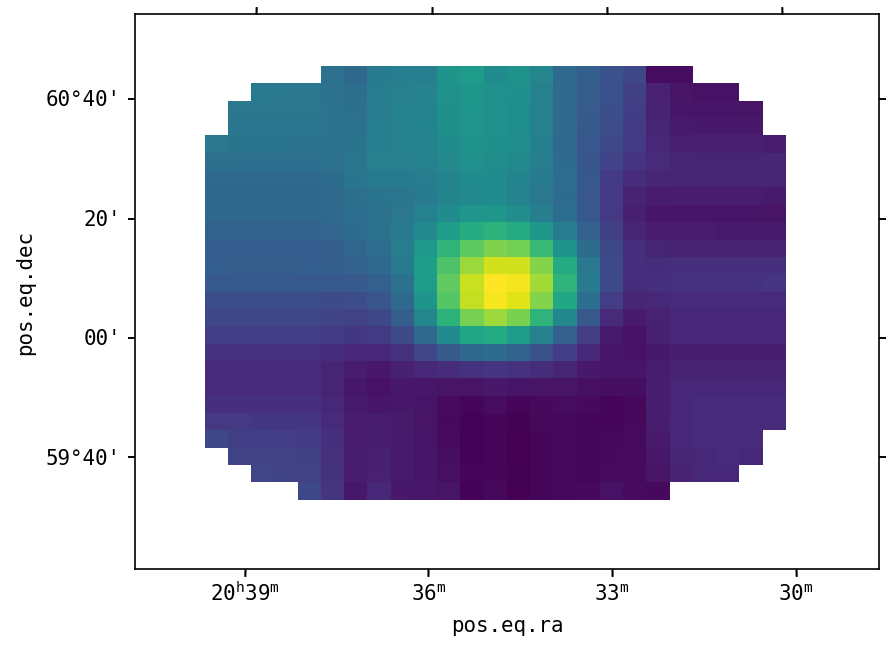

In [28]:
fig = plt.figure(dpi=150)
ax = fig.add_subplot(111, projection=wcs.celestial)
ax.imshow(data[0].mean(axis=0), origin="lower", aspect="auto")

Plot the data for channel 1500. 
We use the celestial representation of the WCS object (`wcs.celestial`) to ignore the non celestial axes (e.g., Stokes and spectral).

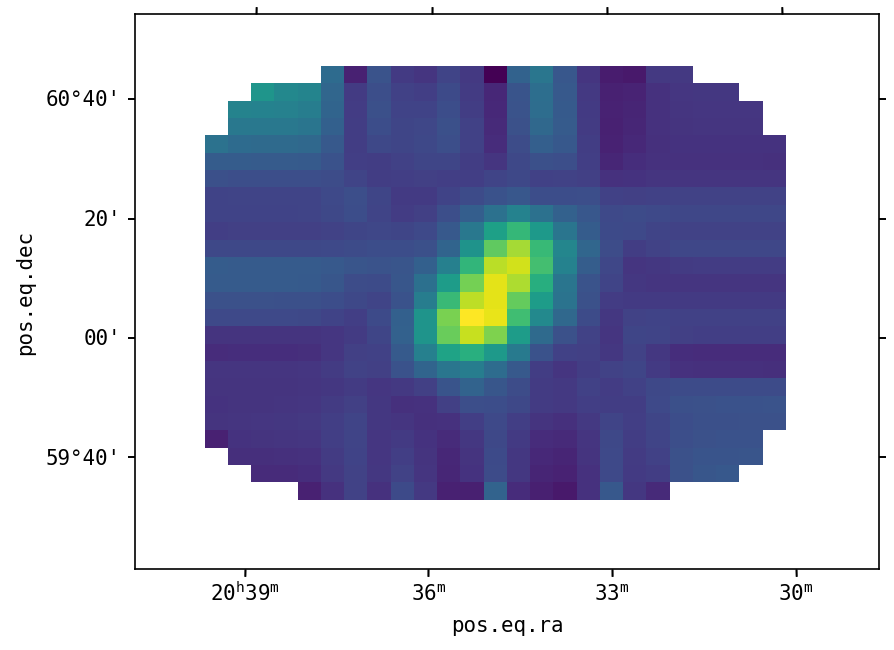

In [29]:
fig = plt.figure(dpi=150)
ax = fig.add_subplot(111, projection=wcs.celestial)
ax.imshow(data[0,1500], origin="lower", aspect="auto")

Plot a PV diagram.
Since we have multiple WCS axes (4), we use the `slices` argument, which tells the WCS object which axes to use for which axis. In this case the first WCS axis (longitude) goes in the y-axis of the figure, the latitude is fixed to its value at pixel 16, the third dimension (spectral axis) is shown in the x-axis, and the last dimensions (Stokes) is fixed to its value at pixel 0 (the only possibility in this case).


See these links for more details on how to use `astropy` for plotting cubes with multiple WCS axes: [link1](https://docs.astropy.org/en/stable/visualization/wcsaxes/slicing_datacubes.html#slicing-the-wcs-object), and [link2](https://docs.astropy.org/en/stable/api/astropy.visualization.wcsaxes.WCSAxes.html#astropy.visualization.wcsaxes.WCSAxes).


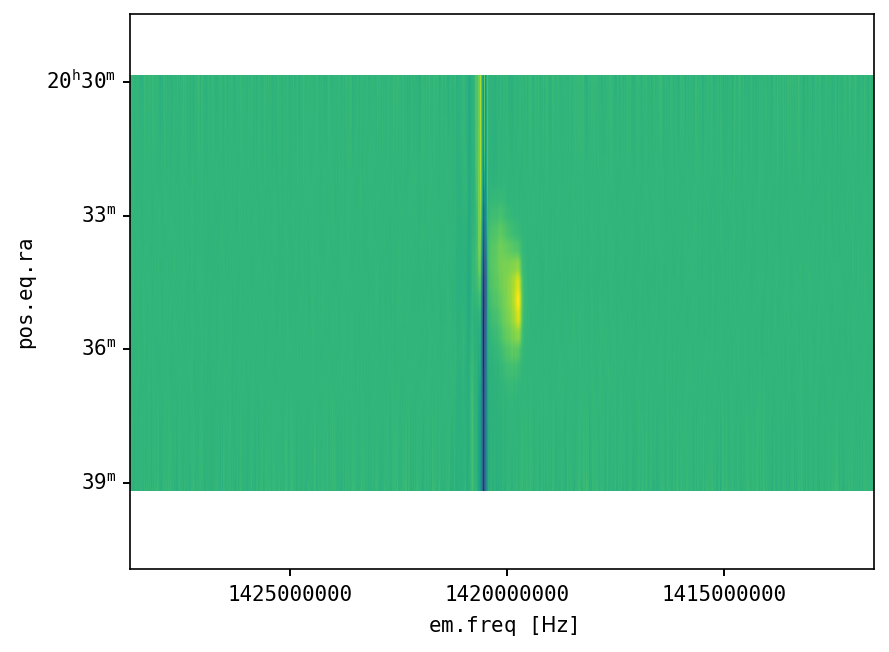

In [30]:
fig = plt.figure(dpi=150)
ax = fig.add_subplot(111, projection=wcs, slices=('y', 16, 'x', 0))
ax.imshow(data[0,:,:,16].T, origin="lower", aspect="auto")

## Final Stats

Finally, at the end we compute some statistics over a spectrum, merely as a checksum if the notebook is reproducable.


In [31]:
spec_bsub_int.stats()  # rms 0.59639255 K - but oddity in mask

10:45:03.037 W Warning: 1 != 2: inconsistency counters in mask usage


{'mean': <Quantity 1.57386063 K>,
 'median': <Quantity 1.61018582 K>,
 'rms': <Quantity 0.59634004 K>,
 'min': <Quantity -4.25514299 K>,
 'max': <Quantity 3.84551533 K>,
 'npt': 4096,
 'nan': 2}

1.1336326856776786

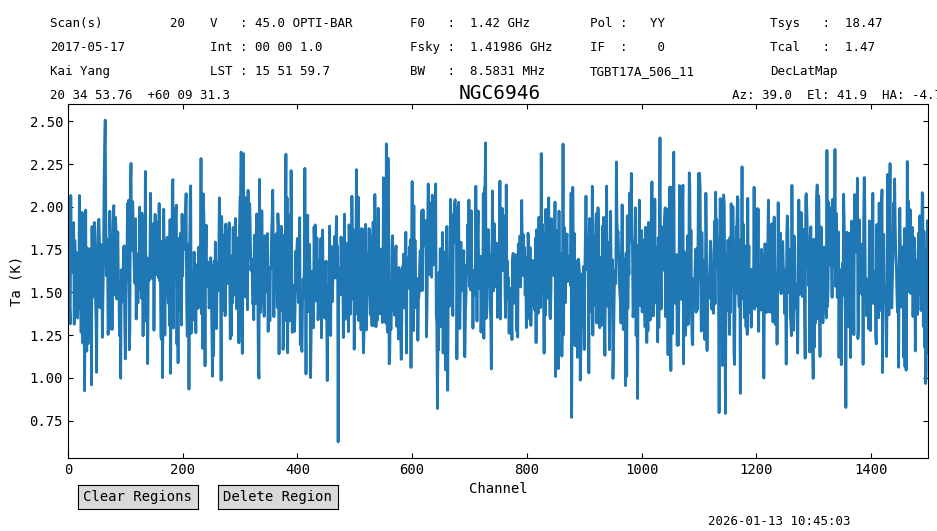

In [32]:
spec_bsub_int[250:1750].plot(xaxis_unit="chan").spectrum.radiometer()  # 1.133795557361736